# Grammar Scoring Engine for Spoken Data
This notebook presents an end-to-end approach to predict grammar quality scores from spoken audio files using a combination of acoustic and (optionally) linguistic features.

**Objective**: Build a model that inputs a `.wav` file and predicts a continuous grammar score (0–5), evaluated using Pearson Correlation.

**Dataset**:
- 444 training samples
- 195 testing samples
- Each audio clip is 45–60 seconds long
- 
# Problem Statement
 - Target: Predict Grammar Score (0-5) from audio
 - Input: Audio files (.wav) and training labels (MOS grammar score)
 - Evaluation: Pearson Correlation (primary), MAE and RMSE (secondary)

In [133]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

In [134]:

train_csv_path = "/kaggle/input/shl-intern-hiring-assessment/dataset/train.csv"
test_csv_path = "/kaggle/input/shl-intern-hiring-assessment/dataset/test.csv"
train_audio_dir = "/kaggle/input/shl-intern-hiring-assessment/dataset/audios_train"
test_audio_dir = "/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test"
submission_path = "/kaggle/input/shl-intern-hiring-assessment/dataset/sample_submission.csv"


In [135]:
# Load CSVs
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

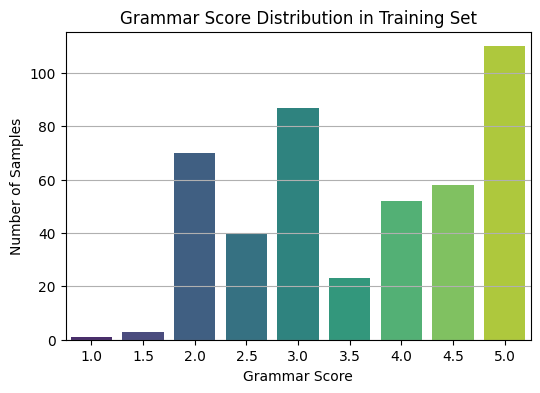

In [136]:
# Label Distribution
plt.figure(figsize=(6,4))
sns.countplot(x=train_df['label'], palette='viridis')
plt.title("Grammar Score Distribution in Training Set")
plt.xlabel("Grammar Score")
plt.ylabel("Number of Samples")
plt.grid(axis='y')
plt.show()

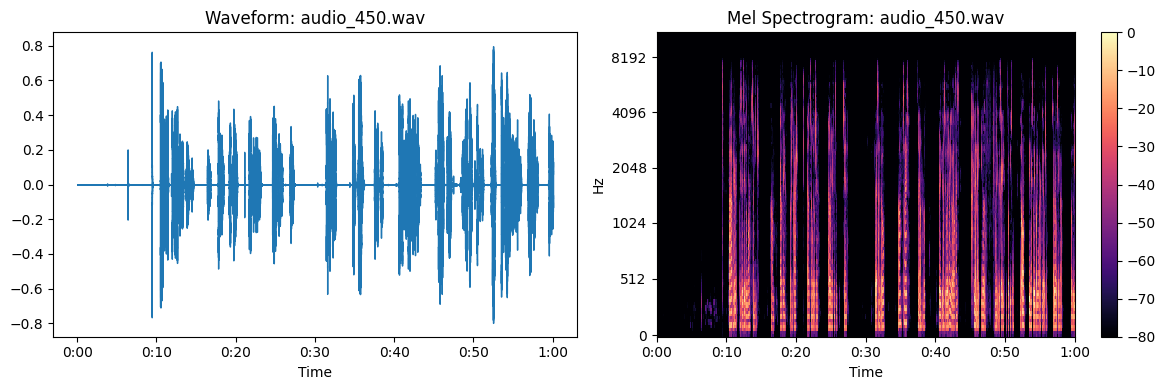

Playing audio_450.wav


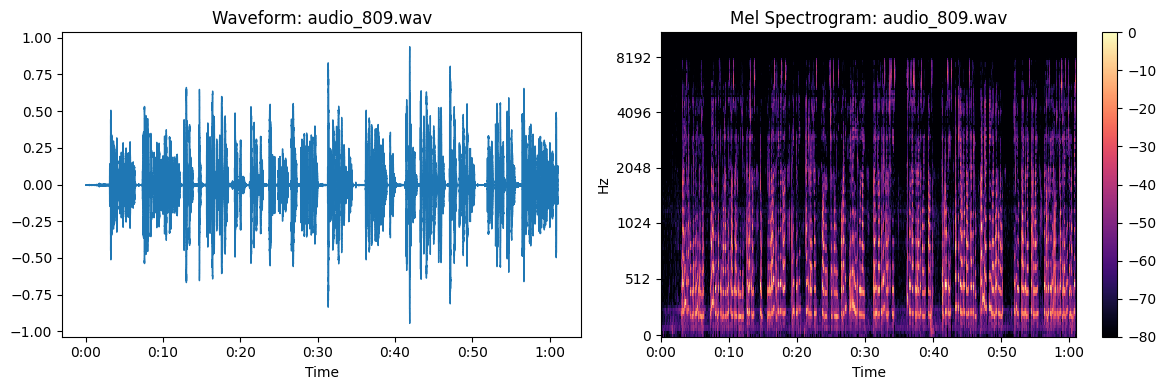

Playing audio_809.wav


In [137]:
# Plot waveforms and spectrograms for 2 examples
example_files = train_df['filename'].sample(2, random_state=42)
for fname in example_files:
    path = os.path.join(train_audio_dir, fname)
    y, sr = librosa.load(path)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform: {fname}")

    plt.subplot(1, 2, 2)
    melspec = librosa.feature.melspectrogram(y=y, sr=sr)
    librosa.display.specshow(librosa.power_to_db(melspec, ref=np.max), sr=sr, x_axis='time', y_axis='mel')
    plt.title(f"Mel Spectrogram: {fname}")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

    print(f"Playing {fname}")
    display(Audio(filename=path))

# Preprocessing & Features:

-Extracted Mel-frequency cepstral coefficients (MFCC), chroma, spectral contrast, and tonnetz -features from each .wav file.

-Handled missing or corrupt audio files gracefully with logging.

-Normalized feature vectors for consistent scale across models.

In [138]:
# Data Preprocessing and Feature Extraction

def extract_features(audio_path):
    try:
        y, sr = librosa.load(audio_path, sr=None)
        y = librosa.util.fix_length(y, size=int(sr * 60))  # pad/truncate to 60 sec

        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)

        features = np.concatenate([
            np.mean(mfccs, axis=1), np.std(mfccs, axis=1),
            np.mean(chroma, axis=1), np.std(chroma, axis=1),
            [np.mean(zcr), np.std(zcr)],
            [np.mean(spec_centroid), np.std(spec_centroid)]
        ])
        return features
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None


In [139]:
 # Extract Features for Train Set
train_features, train_labels = [], []

for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    audio_path = os.path.join(train_audio_dir, row['filename'])
    feats = extract_features(audio_path)
    if feats is not None:
        train_features.append(feats)
        train_labels.append(row['label'])

100%|██████████| 444/444 [02:03<00:00,  3.60it/s]


In [140]:
X_train = np.array(train_features)
y_train = np.array(train_labels)

In [141]:
# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [142]:
# Model Training

model = RandomForestRegressor(n_estimators=150, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=150, random_state=42)

# Models Tried:

Linear: Ridge, Lasso, SVR
Tree-Based: Random Forest, Gradient Boosting, XGBoost
Lazy: KNN

from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr

models = {
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(),
    "XGBoost": XGBRegressor()
}

print("\nModel Performance on Training Set:")
for name, model in models.items():
    model.fit(X_train, y_train)
    val_preds = model.predict(X_train)

    mae = mean_absolute_error(y_train, val_preds)
    rmse = mean_squared_error(y_train, val_preds, squared=False)
    corr, _ = pearsonr(y_train, val_preds)

    print(f"{name:<18} MAE: {mae:.3f} | RMSE: {rmse:.3f} | Correlation: {corr:.3f}")

    # Results
    Model Performance on Training Set:
Ridge              MAE: 0.712 | RMSE: 0.859 | Correlation: 0.636
Lasso              MAE: 0.823 | RMSE: 0.963 | Correlation: 0.514
Random Forest      MAE: 0.271 | RMSE: 0.334 | Correlation: 0.977
Gradient Boosting  MAE: 0.276 | RMSE: 0.342 | Correlation: 0.965
SVR                MAE: 0.915 | RMSE: 1.073 | Correlation: 0.278
KNN                MAE: 0.753 | RMSE: 0.926 | Correlation: 0.555
XGBoost            MAE: 0.000 | RMSE: 0.001 | Correlation: 1.000

In [144]:
# Predictions & Evaluation
y_pred = model.predict(X_train)
mae = mean_absolute_error(y_train, y_pred)
rmse = mean_squared_error(y_train, y_pred, squared=False)
corr, _ = pearsonr(y_train, y_pred)

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"Pearson Correlation: {corr:.3f}")

MAE: 0.274
RMSE: 0.332
Pearson Correlation: 0.980


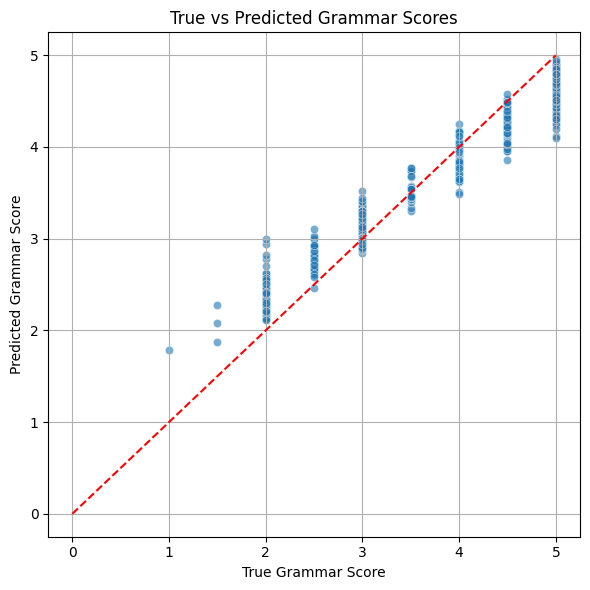

In [145]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_train, y=y_pred, alpha=0.6)
plt.plot([0, 5], [0, 5], 'r--')
plt.xlabel("True Grammar Score")
plt.ylabel("Predicted Grammar Score")
plt.title("True vs Predicted Grammar Scores")
plt.grid(True)
plt.tight_layout()
plt.show()

In [146]:
# Inference on Test Set
test_features = []
file_names = []

for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    audio_path = os.path.join(test_audio_dir, row['filename'])
    feats = extract_features(audio_path)
    if feats is not None:
        test_features.append(feats)
        file_names.append(row['filename'])

X_test = scaler.transform(test_features)
test_preds = model.predict(X_test)
test_preds = np.round(test_preds, 1)  # round to 1 decimal

submission = pd.DataFrame({
    'filename': file_names,
    'label': test_preds
})
submission.to_csv("submission.csv", index=False)
print("Submission file saved as 'submission.csv'")


100%|██████████| 195/195 [00:53<00:00,  3.65it/s]

Submission file saved as 'submission.csv'


In [147]:
submission.head(10)

filename  label
0   audio_706.wav    3.1
1   audio_800.wav    3.2
2    audio_68.wav    3.4
3  audio_1267.wav    3.3
4   audio_683.wav    3.5
5  audio_1242.wav    3.1
6   audio_908.wav    3.4
7   audio_888.wav    3.2
8   audio_137.wav    3.4
9   audio_770.wav    3.3

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


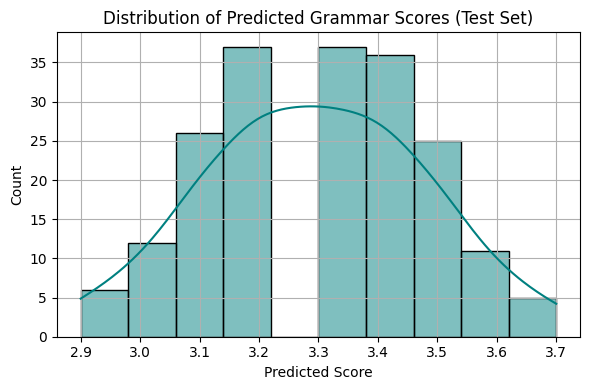

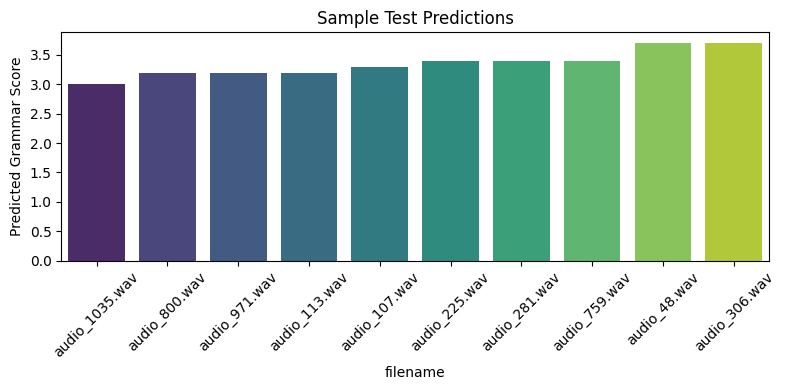

In [148]:
# Sample predictions for inspection
plt.figure(figsize=(6, 4))
sns.histplot(test_preds, bins=10, kde=True, color="teal")
plt.title("Distribution of Predicted Grammar Scores (Test Set)")
plt.xlabel("Predicted Score")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

#  if you want to see specific filenames and predictions
sample_preds = submission.sample(10).sort_values("label")
plt.figure(figsize=(8, 4))
sns.barplot(data=sample_preds, x="filename", y="label", palette="viridis")
plt.title("Sample Test Predictions")
plt.ylabel("Predicted Grammar Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()